In [1]:
import os
import pandas as pd
import numpy as np
import time
import pickle
import random
random.seed(0)
import matplotlib.pyplot as plt
import gc

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
from process import type_score

In [4]:
DATA_DATE = '20190721'
MODEL_DATE = '20190821'

In [5]:
# input files
features_train = OUTPUT + DATA_DATE + '_' + 'dist_ang_ori_bond_cos_train_{}.pickle'
features_test = OUTPUT + DATA_DATE + '_' + 'dist_ang_ori_bond_cos_test_{}.pickle'

In [6]:
# output files
trained_models =  OUTPUT + MODEL_DATE + '_' + 'champs_models_nn_{}.h5'

pred_train_temp = OUTPUT + 'predict_train_temp_{}.pickle'
mols_split = OUTPUT + MODEL_DATE + '_' + 'molecule_name_split.pickle'

pred_train = OUTPUT + MODEL_DATE  + '_' + 'pred_train_0.pickle'

pred_test = OUTPUT + MODEL_DATE  + '_' + 'submission_0.csv'

submission_temp = OUTPUT + 'submission_temp_{}.pickle'

In [7]:
df = pd.DataFrame()
bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']
for b in bond_types:
    df_bond = pd.read_pickle(features_train.format(b)).fillna(0)
    df = pd.concat([df, df_bond], axis=0)

In [8]:
mols = df['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.9)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [9]:
mols_train = mols[pick_train]
mols_val = mols[pick_val]

In [10]:
with open(mols_split, 'wb') as f:
    pickle.dump(mols_train, f)
    pickle.dump(mols_val, f)

In [11]:
df_train = df[df['molecule_name'].isin(mols_train)].sort_values('id')
df_val = df[df['molecule_name'].isin(mols_val)].sort_values('id')

In [12]:
df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,dist_H_0_x,dist_H_1_x,dist_H_2_x,dist_H_3_x,...,orientation_O_2_y,dist_F_0_y,dist_F_1_y,angle_F_0_y,angle_F_1_y,orientation_F_0_y,orientation_F_1_y,cos_3j,cos_3j^2,dist_center
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0.560815,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
0,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,0.560815,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,0.560815,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,0.560815,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.560815,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [13]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Concatenate

Using TensorFlow backend.


In [22]:
def gen_model():
    inputs = Input(shape=(215,), name='input')

    dense0 = Dense(200, activation='relu', use_bias=True, name='dense0')(inputs)
    norm0 = BatchNormalization(name='norm0')(dense0)
    dense1 = Dense(150, activation='tanh', use_bias=True, name='dense1')(norm0)
    norm1 = BatchNormalization(name='norm1')(dense1)
    dense2 = Dense(100, activation='relu', use_bias=True, name='dense2')(norm1)
    norm2 = BatchNormalization(name='norm2')(dense2)
    dense3 = Dense(50, activation='relu',use_bias=True,  name='dense3')(norm2)
    norm3 = BatchNormalization(name='norm3')(dense3)
    
    dense4 = Dense(200, activation='relu', use_bias=True, name='dense4')(inputs)
    norm4 = BatchNormalization(name='norm4')(dense4)
    dense5 = Dense(50, activation='relu', use_bias=True, name='dense5')(norm4)
    norm5 = BatchNormalization(name='norm5')(dense5)
    
    dense6 = Dense(50, activation='tanh',use_bias=True,  name='dense6')(inputs)
    norm6 = BatchNormalization(name='norm6')(dense6)
    
    res_list = [norm3, norm5, norm6]    
    conc_output = Concatenate(name='concat_out')(res_list)

    dense7 = Dense(50, activation='relu',use_bias=True,  name='dense7')(conc_output)
    norm7 = BatchNormalization(name='norm7')(dense7)
    dense8 = Dense(20, activation='tanh', use_bias=True, name='dense8')(norm7)
    norm8 = BatchNormalization(name='norm8')(dense8)
    dense9 = Dense(1, use_bias=True, name='dense9')(norm8)

    return Model(inputs, dense9)

In [23]:
gen_model().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 215)          0                                            
__________________________________________________________________________________________________
dense0 (Dense)                  (None, 200)          43200       input[0][0]                      
__________________________________________________________________________________________________
norm0 (BatchNormalization)      (None, 200)          800         dense0[0][0]                     
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 150)          30150       norm0[0][0]                      
__________________________________________________________________________________________________
norm1 (Bat

---------- 3JHN ----------
Train on 149928 samples, validate on 16488 samples
Epoch 1/100
149928/149928 [==============================] - 10s 70us/step - loss: 0.5911 - val_loss: 0.4920
Epoch 2/100
149928/149928 [==============================] - 10s 64us/step - loss: 0.3980 - val_loss: 0.4149
Epoch 3/100
149928/149928 [==============================] - 8s 51us/step - loss: 0.3522 - val_loss: 0.3457
Epoch 4/100
149928/149928 [==============================] - 8s 52us/step - loss: 0.3226 - val_loss: 0.3209
Epoch 5/100
149928/149928 [==============================] - 10s 64us/step - loss: 0.3040 - val_loss: 0.3378
Epoch 6/100
149928/149928 [==============================] - 9s 63us/step - loss: 0.2890 - val_loss: 0.3192
Epoch 7/100
149928/149928 [==============================] - 9s 61us/step - loss: 0.2761 - val_loss: 0.2729
Epoch 8/100
149928/149928 [==============================] - 10s 65us/step - loss: 0.2682 - val_loss: 0.2820
Epoch 9/100
149928/149928 [===========================

149928/149928 [==============================] - 12s 78us/step - loss: 0.1614 - val_loss: 0.2078
Epoch 76/100
149928/149928 [==============================] - 11s 72us/step - loss: 0.1637 - val_loss: 0.1943
Epoch 77/100
149928/149928 [==============================] - 11s 70us/step - loss: 0.1620 - val_loss: 0.2038
Epoch 78/100
149928/149928 [==============================] - 11s 74us/step - loss: 0.1612 - val_loss: 0.2100
Epoch 79/100
149928/149928 [==============================] - 8s 54us/step - loss: 0.1623 - val_loss: 0.1992
Epoch 80/100
149928/149928 [==============================] - 10s 65us/step - loss: 0.1604 - val_loss: 0.1964
Epoch 81/100
149928/149928 [==============================] - 11s 76us/step - loss: 0.1623 - val_loss: 0.1989
Epoch 82/100
149928/149928 [==============================] - 11s 73us/step - loss: 0.1592 - val_loss: 0.2077
Epoch 83/100
149928/149928 [==============================] - 11s 70us/step - loss: 0.1608 - val_loss: 0.1938
Epoch 84/100
149928/1499

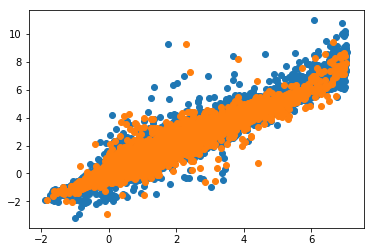

---------- 3JHC ----------
Train on 1359456 samples, validate on 150924 samples
Epoch 1/100
1359456/1359456 [==============================] - 104s 77us/step - loss: 1.0724 - val_loss: 0.9030
Epoch 2/100
1359456/1359456 [==============================] - 94s 69us/step - loss: 0.7895 - val_loss: 0.7838
Epoch 3/100
1359456/1359456 [==============================] - 95s 70us/step - loss: 0.7236 - val_loss: 0.8026
Epoch 4/100
1359456/1359456 [==============================] - 96s 70us/step - loss: 0.6858 - val_loss: 0.6960
Epoch 5/100
1359456/1359456 [==============================] - 96s 70us/step - loss: 0.6593 - val_loss: 0.7161
Epoch 6/100
1359456/1359456 [==============================] - 85s 63us/step - loss: 0.6393 - val_loss: 0.6265
Epoch 7/100
1359456/1359456 [==============================] - 95s 70us/step - loss: 0.6237 - val_loss: 0.6202
Epoch 8/100
1359456/1359456 [==============================] - 92s 68us/step - loss: 0.6106 - val_loss: 0.6073
Epoch 9/100
1359456/1359456 [==

1359456/1359456 [==============================] - 104s 76us/step - loss: 0.4747 - val_loss: 0.4646
Epoch 74/100
1359456/1359456 [==============================] - 107s 78us/step - loss: 0.4739 - val_loss: 0.4779
Epoch 75/100
1359456/1359456 [==============================] - 102s 75us/step - loss: 0.4732 - val_loss: 0.4679
Epoch 76/100
1359456/1359456 [==============================] - 105s 77us/step - loss: 0.4723 - val_loss: 0.4585
Epoch 77/100
1359456/1359456 [==============================] - 102s 75us/step - loss: 0.4714 - val_loss: 0.4620
Epoch 78/100
1359456/1359456 [==============================] - 101s 74us/step - loss: 0.4716 - val_loss: 0.4611
Epoch 79/100
1359456/1359456 [==============================] - 111s 82us/step - loss: 0.4715 - val_loss: 0.4887
Epoch 80/100
1359456/1359456 [==============================] - 97s 71us/step - loss: 0.4708 - val_loss: 0.4516
Epoch 81/100
1359456/1359456 [==============================] - 107s 78us/step - loss: 0.4709 - val_loss: 0.45

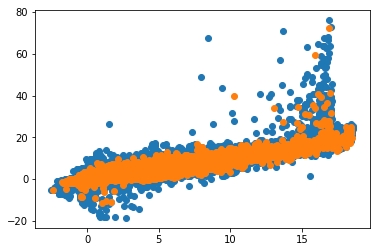

---------- 1JHC ----------
Train on 638223 samples, validate on 71194 samples
Epoch 1/100
638223/638223 [==============================] - 48s 75us/step - loss: 35.3750 - val_loss: 2.2710
Epoch 2/100
638223/638223 [==============================] - 47s 74us/step - loss: 2.2570 - val_loss: 2.0232
Epoch 3/100
638223/638223 [==============================] - 51s 81us/step - loss: 2.0240 - val_loss: 1.7359
Epoch 4/100
638223/638223 [==============================] - 49s 76us/step - loss: 1.9107 - val_loss: 1.6634
Epoch 5/100
638223/638223 [==============================] - 49s 77us/step - loss: 1.8369 - val_loss: 1.9180
Epoch 6/100
638223/638223 [==============================] - 46s 73us/step - loss: 1.8031 - val_loss: 1.9745
Epoch 7/100
638223/638223 [==============================] - 46s 72us/step - loss: 1.7305 - val_loss: 2.2286
Epoch 8/100
638223/638223 [==============================] - 45s 71us/step - loss: 1.7122 - val_loss: 1.7033
Epoch 9/100
638223/638223 [======================

Epoch 75/100
638223/638223 [==============================] - 50s 79us/step - loss: 1.3715 - val_loss: 1.0507
Epoch 76/100
638223/638223 [==============================] - 49s 77us/step - loss: 1.3673 - val_loss: 1.1166
Epoch 77/100
638223/638223 [==============================] - 46s 71us/step - loss: 1.3496 - val_loss: 1.4212
Epoch 78/100
638223/638223 [==============================] - 43s 68us/step - loss: 1.3525 - val_loss: 1.0250
Epoch 79/100
638223/638223 [==============================] - 50s 79us/step - loss: 1.3556 - val_loss: 1.0944
Epoch 80/100
638223/638223 [==============================] - 51s 80us/step - loss: 1.3537 - val_loss: 1.2196
Epoch 81/100
638223/638223 [==============================] - 48s 74us/step - loss: 1.3460 - val_loss: 1.3462
Epoch 82/100
638223/638223 [==============================] - 48s 75us/step - loss: 1.3410 - val_loss: 1.0321
Epoch 83/100
638223/638223 [==============================] - 50s 78us/step - loss: 1.3503 - val_loss: 1.3938
Epoch 84/1

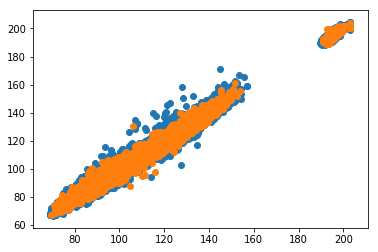

---------- 2JHH ----------
Train on 340048 samples, validate on 37989 samples
Epoch 1/100
340048/340048 [==============================] - 27s 78us/step - loss: 2.6488 - val_loss: 0.7586
Epoch 2/100
340048/340048 [==============================] - 26s 75us/step - loss: 0.6053 - val_loss: 0.6879
Epoch 3/100
340048/340048 [==============================] - 24s 70us/step - loss: 0.5240 - val_loss: 0.5221
Epoch 4/100
340048/340048 [==============================] - 26s 75us/step - loss: 0.4823 - val_loss: 0.5326
Epoch 5/100
340048/340048 [==============================] - 29s 86us/step - loss: 0.4587 - val_loss: 0.4361
Epoch 6/100
340048/340048 [==============================] - 26s 77us/step - loss: 0.4442 - val_loss: 0.4550
Epoch 7/100
340048/340048 [==============================] - 27s 81us/step - loss: 0.4336 - val_loss: 0.4199
Epoch 8/100
340048/340048 [==============================] - 27s 78us/step - loss: 0.4262 - val_loss: 0.3942
Epoch 9/100
340048/340048 [=======================

Epoch 75/100
340048/340048 [==============================] - 26s 78us/step - loss: 0.3159 - val_loss: 0.3210
Epoch 76/100
340048/340048 [==============================] - 24s 72us/step - loss: 0.3154 - val_loss: 0.3877
Epoch 77/100
340048/340048 [==============================] - 24s 71us/step - loss: 0.3169 - val_loss: 0.2767
Epoch 78/100
340048/340048 [==============================] - 27s 81us/step - loss: 0.3141 - val_loss: 0.2668
Epoch 79/100
340048/340048 [==============================] - 26s 78us/step - loss: 0.3131 - val_loss: 0.2851
Epoch 80/100
340048/340048 [==============================] - 27s 79us/step - loss: 0.3104 - val_loss: 0.2520
Epoch 81/100
340048/340048 [==============================] - 24s 69us/step - loss: 0.3144 - val_loss: 0.2987
Epoch 82/100
340048/340048 [==============================] - 27s 81us/step - loss: 0.3131 - val_loss: 0.2767
Epoch 83/100
340048/340048 [==============================] - 29s 85us/step - loss: 0.3075 - val_loss: 0.2606
Epoch 84/1

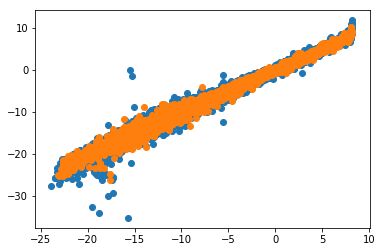

---------- 1JHN ----------
Train on 39231 samples, validate on 4133 samples
Epoch 1/100
39231/39231 [==============================] - 4s 104us/step - loss: 46.7187 - val_loss: 45.2932
Epoch 2/100
39231/39231 [==============================] - 2s 62us/step - loss: 43.6874 - val_loss: 36.5755
Epoch 3/100
39231/39231 [==============================] - 3s 72us/step - loss: 38.2986 - val_loss: 27.9219
Epoch 4/100
39231/39231 [==============================] - 3s 81us/step - loss: 30.5586 - val_loss: 19.6596
Epoch 5/100
39231/39231 [==============================] - 3s 84us/step - loss: 20.5581 - val_loss: 15.4645
Epoch 6/100
39231/39231 [==============================] - 2s 59us/step - loss: 8.5765 - val_loss: 3.6518
Epoch 7/100
39231/39231 [==============================] - 2s 53us/step - loss: 1.6205 - val_loss: 3.0500
Epoch 8/100
39231/39231 [==============================] - 4s 95us/step - loss: 1.2608 - val_loss: 2.8161
Epoch 9/100
39231/39231 [==============================] - 3s 86u

Epoch 77/100
39231/39231 [==============================] - 4s 94us/step - loss: 0.7448 - val_loss: 0.6719
Epoch 78/100
39231/39231 [==============================] - 3s 72us/step - loss: 0.7387 - val_loss: 0.6819
Epoch 79/100
39231/39231 [==============================] - 3s 79us/step - loss: 0.7601 - val_loss: 0.6914
Epoch 80/100
39231/39231 [==============================] - 2s 49us/step - loss: 0.7085 - val_loss: 0.7948
Epoch 81/100
39231/39231 [==============================] - 3s 79us/step - loss: 0.6959 - val_loss: 0.6523
Epoch 82/100
39231/39231 [==============================] - 2s 57us/step - loss: 0.6832 - val_loss: 0.6991
Epoch 83/100
39231/39231 [==============================] - 2s 61us/step - loss: 0.6852 - val_loss: 0.6569
Epoch 84/100
39231/39231 [==============================] - 3s 78us/step - loss: 0.7212 - val_loss: 0.6236
Epoch 85/100
39231/39231 [==============================] - 4s 96us/step - loss: 0.7045 - val_loss: 0.6245
Epoch 86/100
39231/39231 [===========

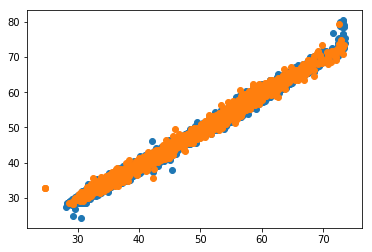

---------- 2JHN ----------
Train on 107439 samples, validate on 11815 samples
Epoch 1/100
107439/107439 [==============================] - 9s 87us/step - loss: 1.5674 - val_loss: 0.9929
Epoch 2/100
107439/107439 [==============================] - 8s 78us/step - loss: 0.6141 - val_loss: 0.5539
Epoch 3/100
107439/107439 [==============================] - 8s 72us/step - loss: 0.5224 - val_loss: 0.5006
Epoch 4/100
107439/107439 [==============================] - 9s 80us/step - loss: 0.4688 - val_loss: 0.4529
Epoch 5/100
107439/107439 [==============================] - 10s 92us/step - loss: 0.4421 - val_loss: 0.4881
Epoch 6/100
107439/107439 [==============================] - 10s 91us/step - loss: 0.4157 - val_loss: 0.4135
Epoch 7/100
107439/107439 [==============================] - 8s 74us/step - loss: 0.3992 - val_loss: 0.4008
Epoch 8/100
107439/107439 [==============================] - 10s 96us/step - loss: 0.3853 - val_loss: 0.4102
Epoch 9/100
107439/107439 [============================

107439/107439 [==============================] - 7s 68us/step - loss: 0.2623 - val_loss: 0.2409
Epoch 76/100
107439/107439 [==============================] - 11s 101us/step - loss: 0.2667 - val_loss: 0.2538
Epoch 77/100
107439/107439 [==============================] - 8s 76us/step - loss: 0.2737 - val_loss: 0.2711
Epoch 78/100
107439/107439 [==============================] - 8s 78us/step - loss: 0.2631 - val_loss: 0.2361
Epoch 79/100
107439/107439 [==============================] - 8s 79us/step - loss: 0.2638 - val_loss: 0.2925
Epoch 80/100
107439/107439 [==============================] - 8s 78us/step - loss: 0.2612 - val_loss: 0.2452
Epoch 81/100
107439/107439 [==============================] - 8s 75us/step - loss: 0.2697 - val_loss: 0.2726
Epoch 82/100
107439/107439 [==============================] - 8s 78us/step - loss: 0.2561 - val_loss: 0.2660
Epoch 83/100
107439/107439 [==============================] - 8s 73us/step - loss: 0.2728 - val_loss: 0.2546
Epoch 84/100
107439/107439 [==

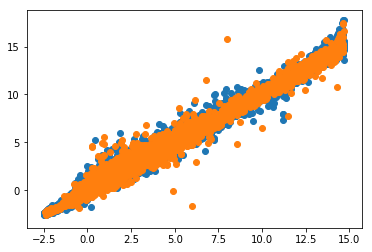

---------- 2JHC ----------
Train on 1026723 samples, validate on 113952 samples
Epoch 1/100
1026723/1026723 [==============================] - 82s 80us/step - loss: 1.1519 - val_loss: 0.9864
Epoch 2/100
1026723/1026723 [==============================] - 85s 82us/step - loss: 0.8428 - val_loss: 0.8299
Epoch 3/100
1026723/1026723 [==============================] - 84s 82us/step - loss: 0.7710 - val_loss: 0.7818
Epoch 4/100
1026723/1026723 [==============================] - 80s 78us/step - loss: 0.7294 - val_loss: 0.7522
Epoch 5/100
1026723/1026723 [==============================] - 82s 80us/step - loss: 0.7013 - val_loss: 0.6873
Epoch 6/100
1026723/1026723 [==============================] - 82s 80us/step - loss: 0.6794 - val_loss: 0.6766
Epoch 7/100
1026723/1026723 [==============================] - 86s 83us/step - loss: 0.6628 - val_loss: 0.7344
Epoch 8/100
1026723/1026723 [==============================] - 87s 85us/step - loss: 0.6475 - val_loss: 0.6344
Epoch 9/100
1026723/1026723 [===

1026723/1026723 [==============================] - 83s 81us/step - loss: 0.4956 - val_loss: 0.4580
Epoch 74/100
1026723/1026723 [==============================] - 86s 83us/step - loss: 0.4937 - val_loss: 0.4688
Epoch 75/100
1026723/1026723 [==============================] - 86s 84us/step - loss: 0.4949 - val_loss: 0.4722
Epoch 76/100
1026723/1026723 [==============================] - 86s 84us/step - loss: 0.4930 - val_loss: 0.4979
Epoch 77/100
1026723/1026723 [==============================] - 85s 82us/step - loss: 0.4921 - val_loss: 0.4534
Epoch 78/100
1026723/1026723 [==============================] - 75s 73us/step - loss: 0.4925 - val_loss: 0.4529
Epoch 79/100
1026723/1026723 [==============================] - 89s 87us/step - loss: 0.4910 - val_loss: 0.4646
Epoch 80/100
1026723/1026723 [==============================] - 77s 75us/step - loss: 0.4912 - val_loss: 0.4576
Epoch 81/100
1026723/1026723 [==============================] - 90s 88us/step - loss: 0.4911 - val_loss: 0.4540
Epoch

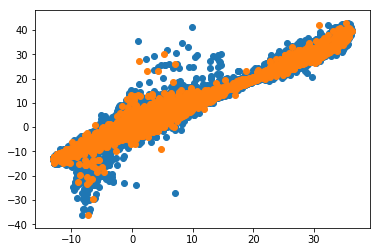

---------- 3JHH ----------
Train on 531590 samples, validate on 59022 samples
Epoch 1/100
531590/531590 [==============================] - 44s 83us/step - loss: 0.9846 - val_loss: 0.5560
Epoch 2/100
531590/531590 [==============================] - 40s 75us/step - loss: 0.4968 - val_loss: 0.5053
Epoch 3/100
531590/531590 [==============================] - 46s 87us/step - loss: 0.4493 - val_loss: 0.4797
Epoch 4/100
531590/531590 [==============================] - 42s 79us/step - loss: 0.4189 - val_loss: 0.4303
Epoch 5/100
531590/531590 [==============================] - 40s 75us/step - loss: 0.4073 - val_loss: 0.4912
Epoch 6/100
531590/531590 [==============================] - 42s 78us/step - loss: 0.3917 - val_loss: 0.4418
Epoch 7/100
531590/531590 [==============================] - 46s 86us/step - loss: 0.3828 - val_loss: 0.3667
Epoch 8/100
531590/531590 [==============================] - 40s 75us/step - loss: 0.3728 - val_loss: 0.3849
Epoch 9/100
531590/531590 [=======================

Epoch 75/100
531590/531590 [==============================] - 46s 87us/step - loss: 0.2927 - val_loss: 0.2546
Epoch 76/100
531590/531590 [==============================] - 45s 84us/step - loss: 0.2930 - val_loss: 0.2729
Epoch 77/100
531590/531590 [==============================] - 43s 81us/step - loss: 0.2949 - val_loss: 0.2429
Epoch 78/100
531590/531590 [==============================] - 47s 89us/step - loss: 0.2887 - val_loss: 0.2543
Epoch 79/100
531590/531590 [==============================] - 42s 79us/step - loss: 0.2944 - val_loss: 0.2725
Epoch 80/100
531590/531590 [==============================] - 48s 90us/step - loss: 0.2927 - val_loss: 0.2506
Epoch 81/100
531590/531590 [==============================] - 42s 79us/step - loss: 0.2885 - val_loss: 0.2471
Epoch 82/100
531590/531590 [==============================] - 42s 78us/step - loss: 0.2934 - val_loss: 0.2440
Epoch 83/100
531590/531590 [==============================] - 40s 74us/step - loss: 0.2921 - val_loss: 0.2736
Epoch 84/1

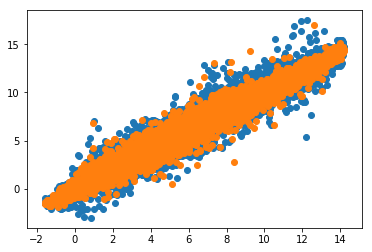

total elapsed_time:9.08[hours]


In [24]:
scores = []
start0 = time.time()

for i, b in enumerate(bond_types):
    print('-'*10, b, '-'*10)
    
    y_train_pred_b =[]
    y_val_pred_b =[]
    
    df_train_b = df_train.query('type == "{}"'.format(b))
    y_train = df_train_b['scalar_coupling_constant'].values
    y_train = np.hstack([y_train, 0])
    X_train = df_train_b[df_train_b.columns[6:]].values
    X_train = np.vstack([X_train, np.zeros(215)])

    df_val_b = df_val.query('type == "{}"'.format(b))
    y_val = df_val_b['scalar_coupling_constant'].values
    X_val = df_val_b[df_val_b.columns[6:]].values

    model = gen_model()
    model.compile(loss='mean_absolute_error',
                  optimizer='adam')
    
    model.fit(X_train, y_train,
          batch_size=256,
          epochs=100,
          verbose=1,
          validation_data=(X_val, y_val))
    
    X_train = X_train[:-1]
    y_train = y_train[:-1]
    y_train_pred = model.predict(X_train).reshape(-1)
    df_train_pred_b = pd.DataFrame([df_train_b['id'], y_train_pred], index=['id', 'scalar_coupling_constant']).T
    
    y_val_pred = model.predict(X_val).reshape(-1)
    df_val_pred_b = pd.DataFrame([df_val_b['id'], y_val_pred], index=['id', 'scalar_coupling_constant']).T
    
    df_pred_b = pd.concat([df_train_pred_b, df_val_pred_b], axis=0)
    df_pred_b.to_pickle(pred_train_temp.format(b))
    
    score_train = type_score(y_train_pred, y_train)
    score_val = type_score(y_val_pred, y_val)
    
    print('score train: %.2f' % score_train)
    print('score valid: %.2f' % score_val)
    
    plt.scatter(y_train_pred, y_train)
    plt.scatter(y_val_pred, y_val)
    plt.show()
    
    model.save(trained_models.format(b), include_optimizer=False)
    
    scores.append(score_val)
    gc.collect()
elapsed_time = time.time() - start0
print ("total elapsed_time:%.2f" % (elapsed_time/3600) + "[hours]")


In [25]:
print('type score:', scores)
print('total score:', np.array(scores).mean())

# bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']
# type score: [-2.213330811075121, -1.3581258350105094, -0.7845050130296711, -2.1655013094988513, -1.4024121799402647, -1.9751865470643377, -1.499394936229838, -2.1188348800106724]
# total score: -1.689661438982408

# type score: [-2.226743610048564, -1.409414866258736, -0.7786536175446308, -2.1293185234551006, -1.3491208855275625, -1.973349148953741, -1.540499443927113, -2.1123116402385937]
# total score: -1.689926466994255


type score: [-1.6563138091053946, -0.7944631358634355, 0.03022558730645388, -1.3747493772386015, -0.3157842595825757, -1.3574589554241652, -0.7943291785088513, -1.442908013814183]
total score: -0.9632226427788441
